# Predicting Credit Card Default with Machine Learning

## Table of contents

1. [Introduction](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Preprocessing and transformations](#4) 
5. [Baseline model](#5)
6. [Linear models](#6)
7. [Different models](#7)
8. [Feature selection](#8)
9. [Hyperparameter optimization](#9)
10. [Interpretation and feature importances](#10) 
11. [Results on the test set](#11)
12. [Summary of the results](#12)
13. [Your takeaway from the course](#13)

## Imports

In [2]:
import os

%matplotlib inline
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import tests_hw5
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from lightgbm.sklearn import LGBMClassifier
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier


## 1. Introduction of the Problem <a name="1"></a>
<hr>

I am doing a classification problem of predicting whether a credit card client will default or not. 
For this problem, I am using [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills. I am using linear and nonlinear models for this problem, and I also include my analysis on the results in the end.

I think the problem is well proposed, and the data set seems to have appropriate amount of and relevant features to predict the target. We can see each credit card holder's background, such as their gender and education level, as well as their financial history. We also have enough examples (30,000) to train, validate, and test our model.

One thing that I am bit concerned is that the data set only contains about 5 months of financial history, which might not be enough for our purposes.

In [3]:
credit_card_df = pd.read_csv('data/UCI_Credit_Card.csv')
credit_card_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


<!-- END QUESTION -->

<br><br>

## 2. Data splitting <a name="2"></a>
<hr>

I split the data into train (70%) and test (30%) portions with `random_state=123`.


In [4]:
X = credit_card_df.drop(columns='default.payment.next.month')
y = credit_card_df['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

Note that I used the stratified split to make sure we have the same distribution of 1s and 0s in both test and train split.

<!-- END QUESTION -->

<br><br>

## 3. Exploratory Data Analysis (EDA) <a name="3"></a>
<hr>

Here, I performed exploratory data analysis on the train set. I included at least several summary statistics and visualizations that you find useful, and accompany each one with a sentence explaining it. I also picked appropriate metric/metrics for assessment. 

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 14451 to 13416
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         21000 non-null  int64  
 1   LIMIT_BAL  21000 non-null  float64
 2   SEX        21000 non-null  int64  
 3   EDUCATION  21000 non-null  int64  
 4   MARRIAGE   21000 non-null  int64  
 5   AGE        21000 non-null  int64  
 6   PAY_0      21000 non-null  int64  
 7   PAY_2      21000 non-null  int64  
 8   PAY_3      21000 non-null  int64  
 9   PAY_4      21000 non-null  int64  
 10  PAY_5      21000 non-null  int64  
 11  PAY_6      21000 non-null  int64  
 12  BILL_AMT1  21000 non-null  float64
 13  BILL_AMT2  21000 non-null  float64
 14  BILL_AMT3  21000 non-null  float64
 15  BILL_AMT4  21000 non-null  float64
 16  BILL_AMT5  21000 non-null  float64
 17  BILL_AMT6  21000 non-null  float64
 18  PAY_AMT1   21000 non-null  float64
 19  PAY_AMT2   21000 non-null  float64
 20  PA

In [6]:
X_train.describe().loc['count'].unique()

array([21000.])

We don't have missing values here. All features are present in the train set for each example.

Next, I plot histograms of feature `LIMIT_BAL`, `SEX`, `EDUCATION`, `MARRIAGE`, `AGE` and group by target.

In [7]:
train_df = pd.concat([X_train, y_train], axis=1)

In [8]:
numeric_features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']

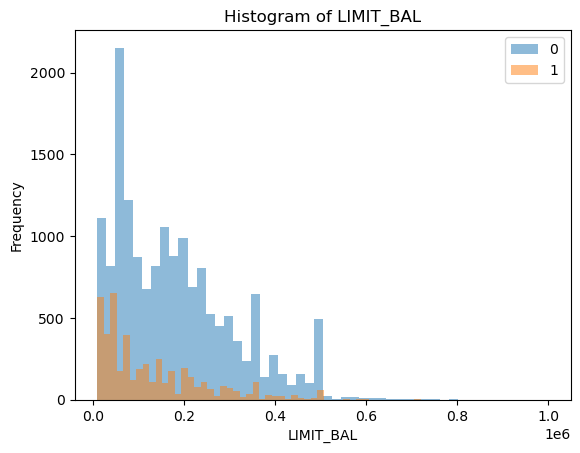

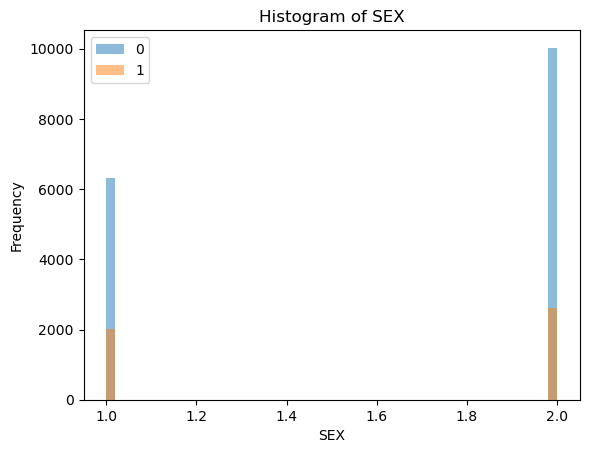

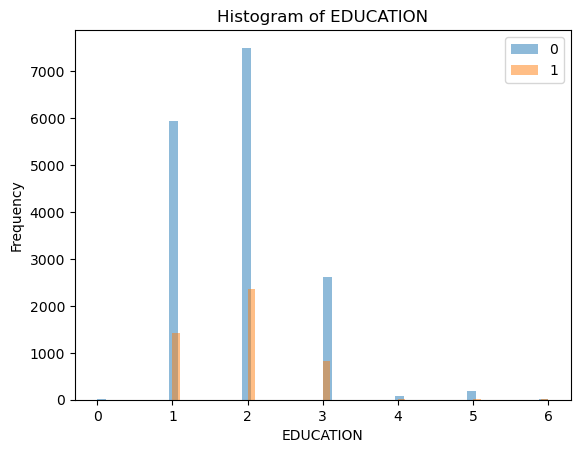

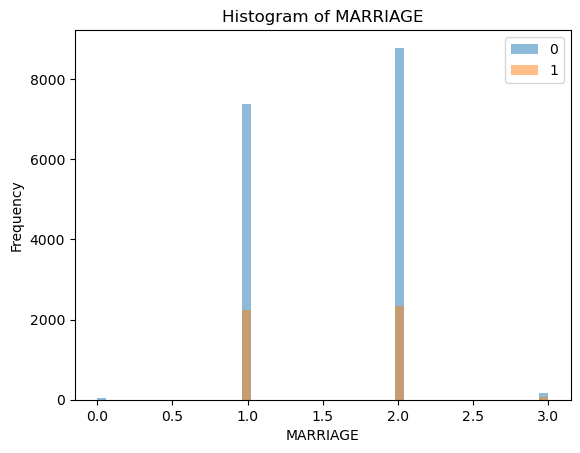

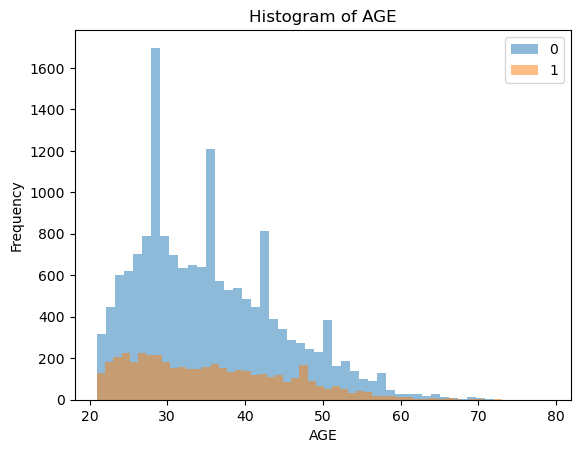

In [9]:
for num_feat in numeric_features:
    train_df.groupby('default.payment.next.month')[num_feat].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(num_feat)
    plt.title("Histogram of " + num_feat)
    plt.show()

Next, I take the mean values of the three groups of features `PAY_n`, `BILL_AMTn`, `PAY_AMTn`, and plot their histograms and group by the target to see if they are relevant. I do this because I think that each of these groups of features together (rather than each feature on its own) will contribute to the prediction.

In [10]:
train_df['MEAN_PAY'] = (train_df['PAY_0'] + train_df['PAY_2'] + train_df['PAY_3'] + train_df['PAY_4'] + train_df['PAY_5'] + train_df['PAY_6'])*1/6
train_df['MEAN_BILL_AMT'] = (train_df['BILL_AMT1'] + train_df['BILL_AMT2'] + train_df['BILL_AMT3'] + train_df['BILL_AMT4'] + train_df['BILL_AMT5'] + train_df['BILL_AMT6']) * 1/6
train_df['MEAN_PAY_AMT'] = (train_df['PAY_AMT1'] + train_df['PAY_AMT2'] + train_df['PAY_AMT3'] + train_df['PAY_AMT4'] + train_df['PAY_AMT5'] + train_df['PAY_AMT6']) * 1/6

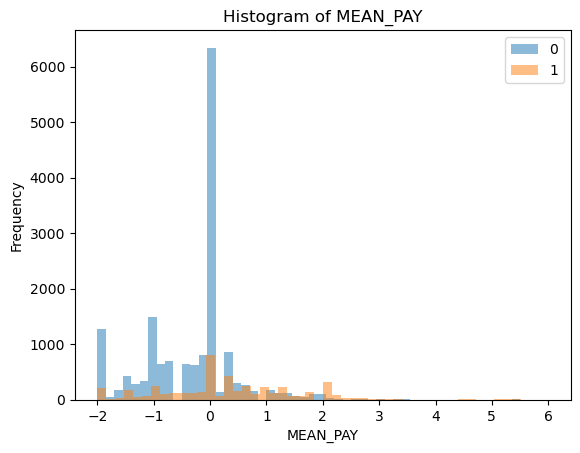

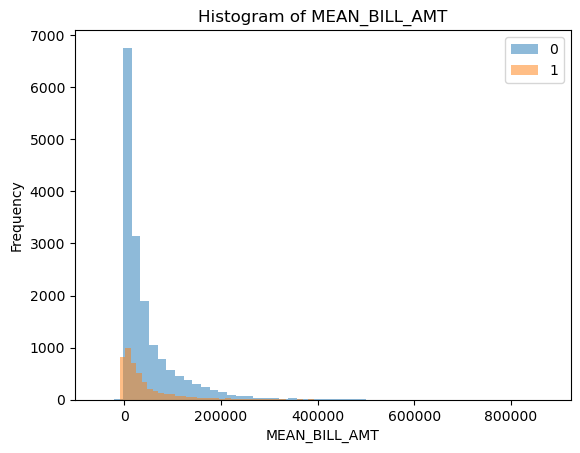

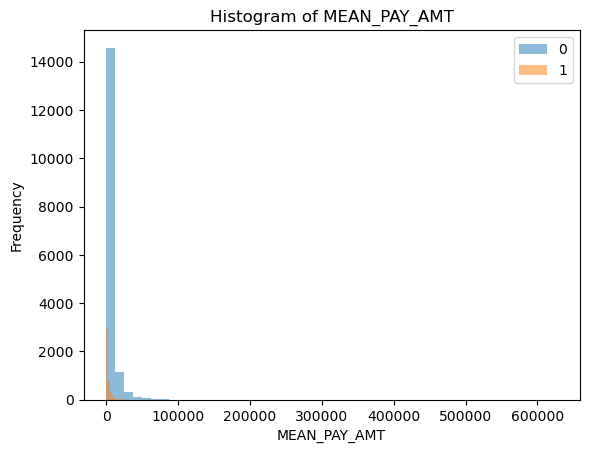

In [11]:
summed_features = ['MEAN_PAY', 'MEAN_BILL_AMT', 'MEAN_PAY_AMT']
for sum_feat in summed_features:
    train_df.groupby('default.payment.next.month')[sum_feat].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(sum_feat)
    plt.title("Histogram of " + sum_feat)
    plt.show()

I check the distributions of the histograms. If the two distributions are two similar, then we can decide that such features don't have much predicting power, and hence I dropped them.

Next, we check linear correlations between the features with the following heatmap.

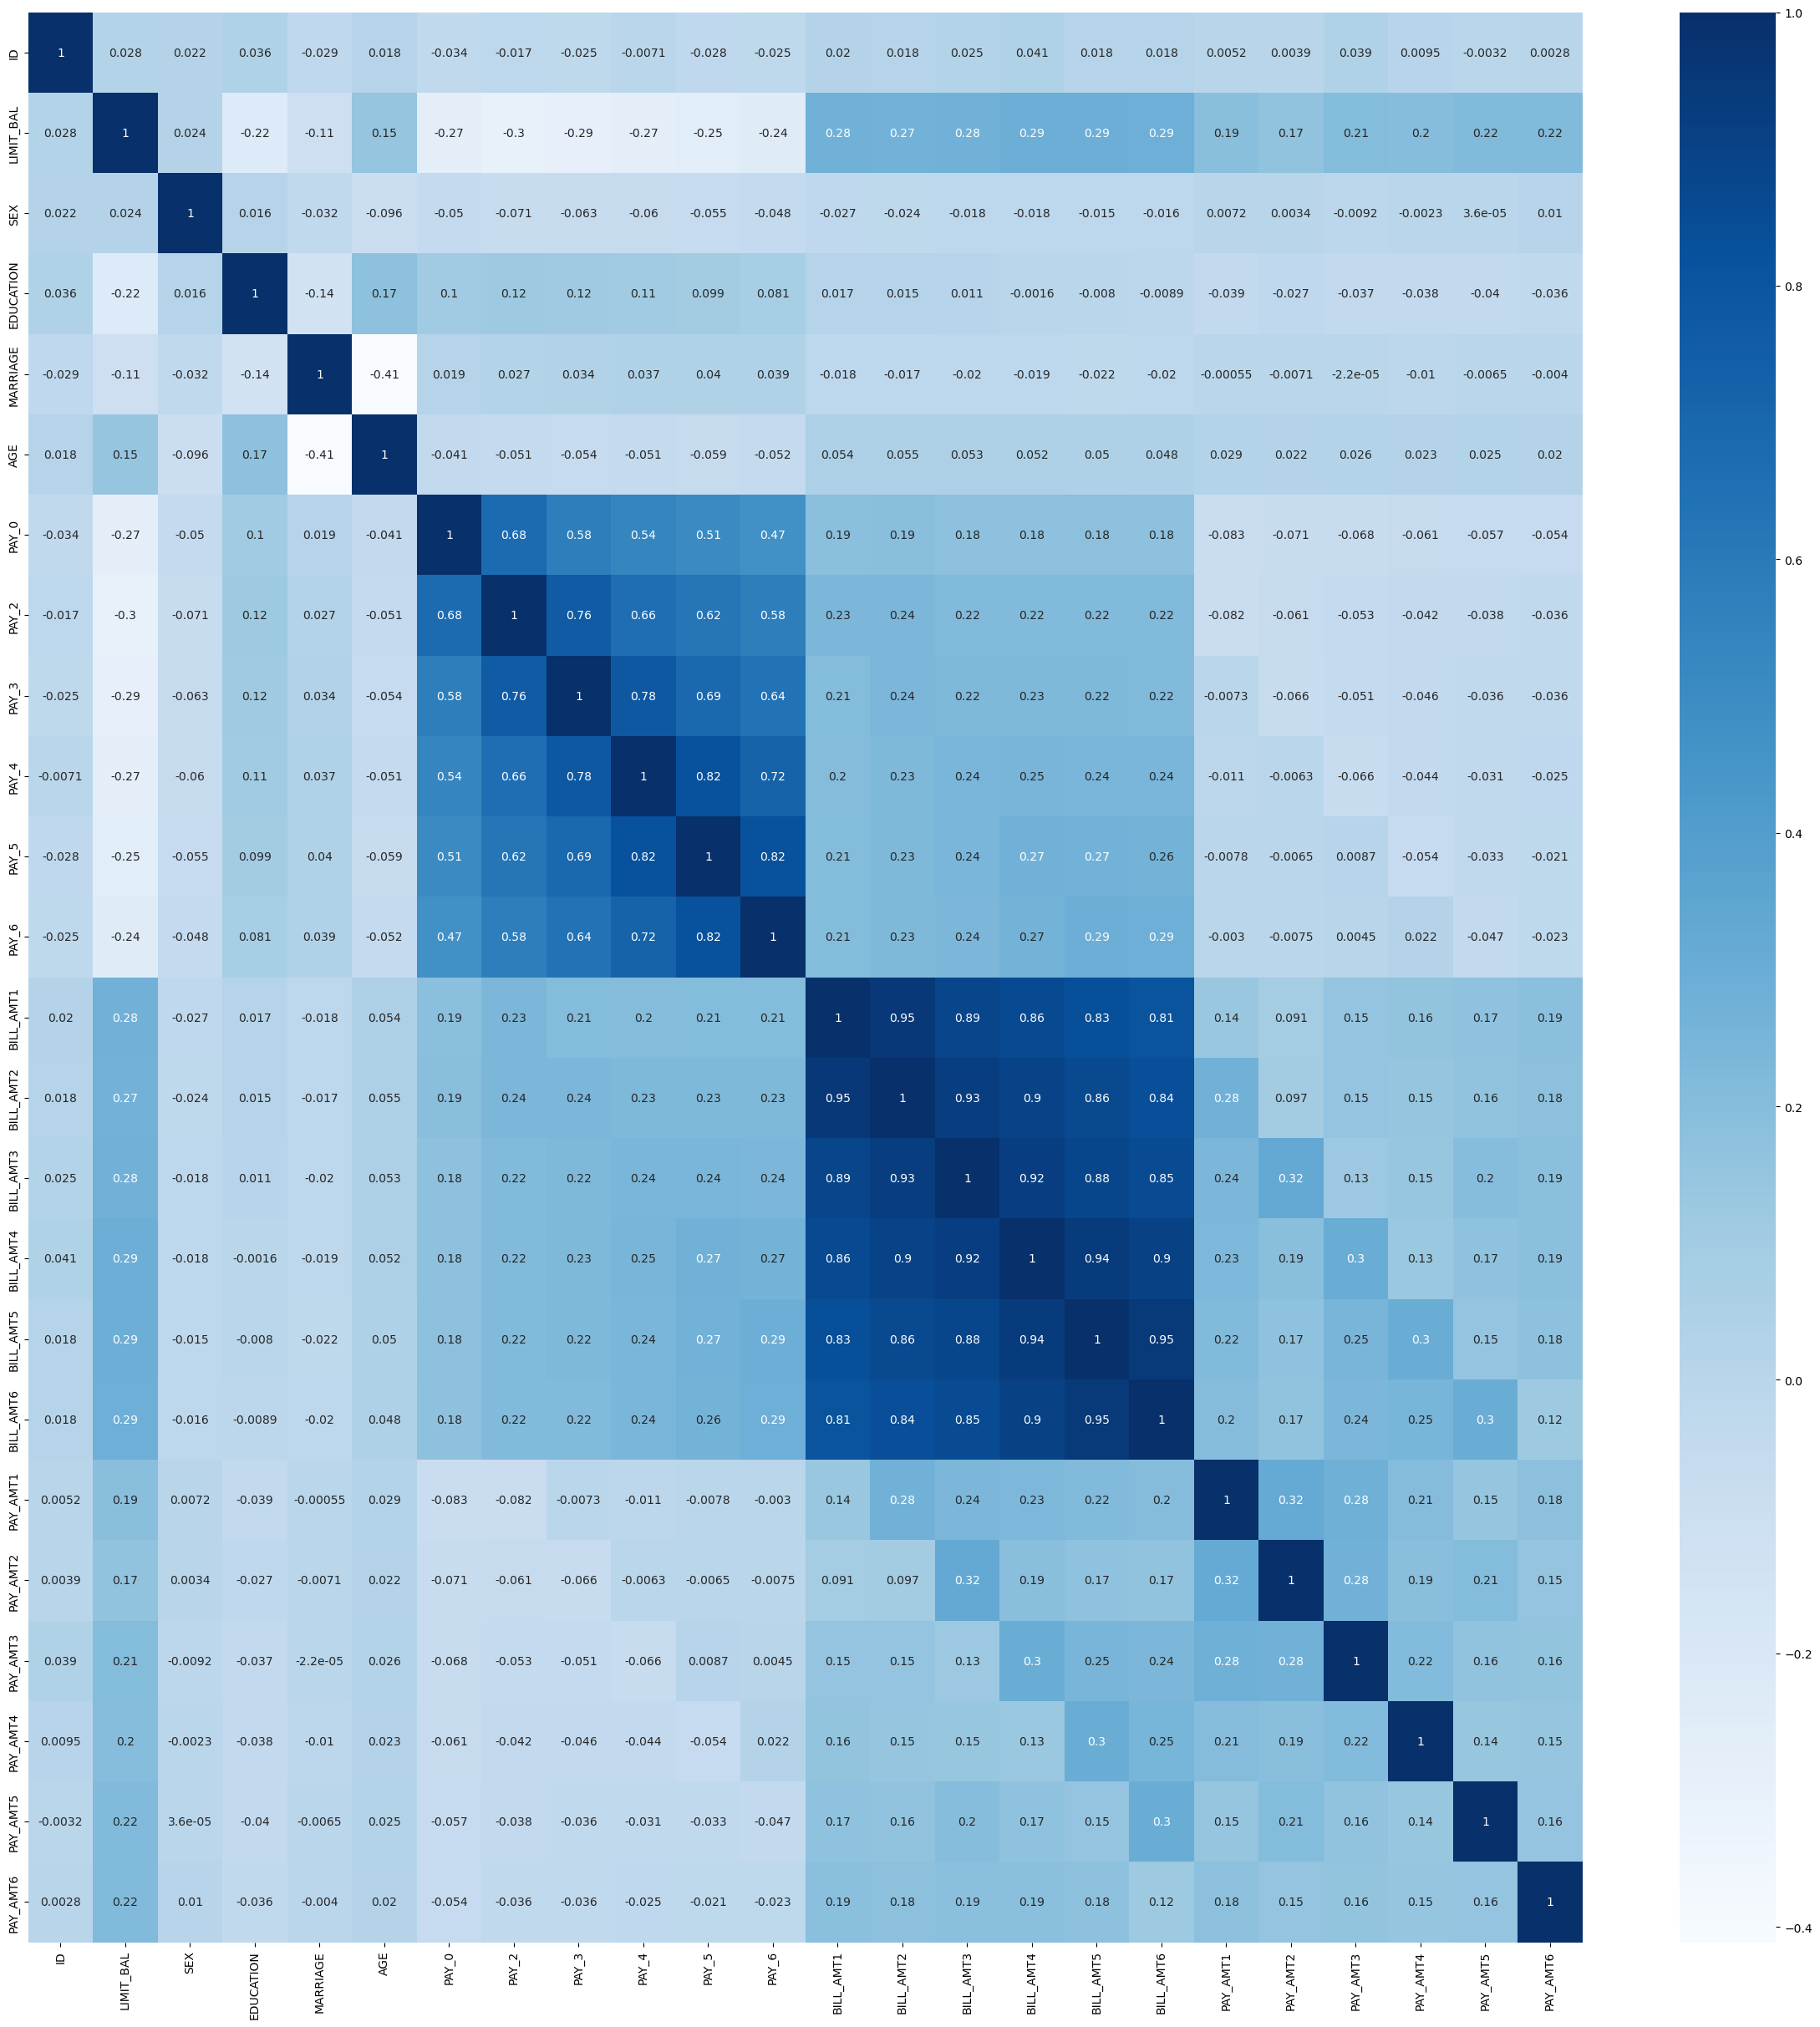

In [12]:
import seaborn as sns
cor = X_train.corr()
plt.figure(figsize=(30,30))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

### Summary of our Initial Observations

Based on the histogram, we observe that the group of features `PAY_n` seems to have the most predicting power as its corresponding histogram has the highest variation. Whereas, the groups of features `PAY_AMTn` and `BILL_AMTn` seem to have the least predicting power as they generate histograms that have the exact same distribution. And based on the heatmap, we see that that there are strong correlations among the group of features `BILL_AMTn`. We don't need all of them.

Therefore, in our preliminary analysis, we keep the following features: 

- `LIMIT_BAL`
- `EDUCATION`
- `MARRIAGE`
- `AGE`
- `PAY_0`
- `PAY_2`
- `PAY_3`
- `PAY_4` 
- `PAY_5`
- `PAY_6`

We also dropped the feature `SEX` due to ethical concerns.

### Choosing Metrics

We decide to use precision and recall as our metrics to assess the accuracy of our model. These two are suitable here as we are building a classifier and it's important to deal with the problems of false negative and false positive, especially false negative in detecting the cases of financial default.

<!-- END QUESTION -->

<br><br>

## 4. Preprocessing and transformations <a name="4"></a>
<hr>

I identified different feature types and the transformations you would apply on each feature type. And I defined a column transformer.

First, note that there are illegitimate inputs in features `EDUCATION`, `MARRIAGE`, `PAY_n`.

In [13]:
print("Unique values in...\n")
print("EDUCATION: " + str(X_train['EDUCATION'].sort_values().unique()))
print("MARRIAGE: " + str(X_train['MARRIAGE'].sort_values().unique()))
print("PAY_0: " + str(X_train['PAY_0'].sort_values().unique()))
print("PAY_2: " + str(X_train['PAY_2'].sort_values().unique()))
print("PAY_3: " + str(X_train['PAY_3'].sort_values().unique()))
print("PAY_4: " + str(X_train['PAY_4'].sort_values().unique()))
print("PAY_5: " + str(X_train['PAY_5'].sort_values().unique()))
print("PAY_6: " + str(X_train['PAY_6'].sort_values().unique()))

Unique values in...

EDUCATION: [0 1 2 3 4 5 6]
MARRIAGE: [0 1 2 3]
PAY_0: [-2 -1  0  1  2  3  4  5  6  7  8]
PAY_2: [-2 -1  0  1  2  3  4  5  6  7]
PAY_3: [-2 -1  0  1  2  3  4  5  6  7  8]
PAY_4: [-2 -1  0  1  2  3  4  5  6  7  8]
PAY_5: [-2 -1  0  2  3  4  5  6  7  8]
PAY_6: [-2 -1  0  2  3  4  5  6  7  8]


Reminder that the scales for each of these features are:

- `EDUCATION` : 1=graduate school ,2=university, 3=high school, 4=others, 5=unknown, 6=unknown
- `MARRIAGE` : 1=married, 2=single, 3=others
- `PAY_n` : -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above

Therefore, we first replace illegitimate values with `NaN`.

In [14]:
# the values of 0 are not defined in EDUCATION, so we can replace them by NaN in both training data and testing data
X_train['EDUCATION'] = X_train['EDUCATION'].replace([0], np.nan)
X_test['EDUCATION'] = X_test['EDUCATION'].replace([0], np.nan)

In [15]:
# the values of 0 are not defined in MARRIAGE, so we replace them by NaN in both training data and testing data
X_train['MARRIAGE'] = X_train['MARRIAGE'].replace([0], np.nan)
X_test['MARRIAGE'] = X_test['MARRIAGE'].replace([0], np.nan)

In [16]:
# values of 0 and -2 are not defined in PAY_n, so we replace them by NaN in both training data and testing data
for i in range(0, 7):
    if i == 1:
        continue
    column_name = 'PAY_' + str(i)
    X_train[column_name] = X_train[column_name].replace([0, -2], np.nan)
    X_test[column_name] = X_test[column_name].replace([0, -2], np.nan)

We also decide to delete values of 4, 5, and 6 in the feature `EDUCATION` as they don't convey sufficient information.

In [17]:
X_train['EDUCATION'] = X_train['EDUCATION'].replace([4, 5, 6], np.nan)
X_test['EDUCATION'] = X_test['EDUCATION'].replace([4, 5, 6], np.nan)

We also decide to replace the numerical values in the feature `MARRIAGE` to their more descriptive string values.

In [18]:
value_mapping = {1: 'married', 2: 'single', 3: 'others'}
X_train['MARRIAGE'] = X_train['MARRIAGE'].replace(value_mapping)
X_test['MARRIAGE'] = X_test['MARRIAGE'].replace(value_mapping)

And they we proceed to define our column transformers. Below is our strategy:

Drop : `ID`, `SEX`, `BILL_AMTn`, `PAY_AMTn`

Scale : `LIMIT_BAL`, `AGE`

Impute : `EDUCATION`, `PAY_n`

Impute + OneHotEncode : `MARRIAGE`

In [19]:
scale_features = ["LIMIT_BAL", "AGE"]
impute_and_oneHotEncode_features = ["MARRIAGE"]
impute_only_features = ["EDUCATION", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
drop_features = ["ID", "SEX", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]

In [20]:
ct = make_column_transformer(
    (StandardScaler(), scale_features),
    (   
        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(categories=[["married", "single", "others"]])), 
        impute_and_oneHotEncode_features
    ), 
    (SimpleImputer(strategy="median"), impute_only_features),  
    ("drop", drop_features),  
)
ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['LIMIT_BAL', 'AGE']),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(categories=[['married',
                                                                             'single',
                                                                             'others']]))]),
                                 ['MARRIAGE']),
                                ('simpleimputer',
                                 SimpleImputer(strategy='median'),
                                 ['EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3',
                                  'PAY_4', 'PAY_5', 'PAY_6']),
                                ('drop', 'drop',
                                 ['ID', 'SEX', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6'])])

And here is our transformed data set:

In [21]:
X_train_transformed = ct.fit_transform(X_train)

In [22]:
column_names = (
    scale_features +
    ct.named_transformers_['pipeline'].named_steps['onehotencoder'].get_feature_names_out(['MARRIAGE']).tolist() +
    impute_only_features
)

In [23]:
pd.DataFrame(X_train_transformed, columns=column_names).head()

,LIMIT_BAL,AGE,MARRIAGE_married,MARRIAGE_single,MARRIAGE_others,EDUCATION,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,-1.136839,1.790069,1.0,0.0,0.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.480315,-1.245504,0.0,1.0,0.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1.481411,-0.486611,0.0,1.0,0.0,3.0,1.0,-1.0,2.0,-1.0,-1.0,-1.0
3,-0.597787,-1.028677,1.0,0.0,0.0,2.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.136839,-0.703437,0.0,1.0,0.0,1.0,1.0,2.0,-1.0,-1.0,-1.0,2.0


Reinitialize the column transformer because we've fitted it before.

In [24]:
ct = make_column_transformer(
    (StandardScaler(), scale_features),
    (   
        make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(categories=[["married", "single", "others"]])), 
        impute_and_oneHotEncode_features
    ), 
    (SimpleImputer(strategy="median"), impute_only_features),  
    ("drop", drop_features),  
)

<!-- END QUESTION -->

<br><br>

## 5. Baseline model <a name="5"></a>
<hr>

I used `scikit-learn`'s baseline model here.

In [25]:
dummy = DummyClassifier()

In [26]:
pd.DataFrame(cross_val_score(dummy, X_train, y_train), columns=['Accuracy'])

,Accuracy
0,0.77881
1,0.77881
2,0.77881
3,0.77881
4,0.77881


### Summary of Baseline Model
 
The dummy model simply predicts based on the target. If `y_train` has more 0s then it will always predict 0, and vice versa. 

Our dummy model has an accuracy of 77.9%, which means that our data set is a bit unbalanced (22.1% to 77.9%). And look into the data, we find that in the target set about 77.9% is 0, i.e. not default.

<br><br>


## 6. Linear models <a name="6"></a>
<hr>

I tried a linear model as a first real attempt. I carried out hyperparameter tuning to explore different values for the complexity hyperparameter. I summerized my results with cross-validation scores along with standard deviation. 

I chose logistic regression as our linear model.

Since our training data is a bit unbalanced, I included the parameter `class_weight='balanced'` in our logistic regression model.

In [27]:
scores_dict = {
    'C' : 10.0 ** np.arange(-4, 3, 1),
    'mean_train_scores' : list(),
    'std_train_scores' : list(),
    'mean_cv_scores' : list(),
    'std_cv_scores' : list()
}

for C in scores_dict['C']:
    pipe = make_pipeline(ct, LogisticRegression(C=C, max_iter=100, class_weight='balanced'))
    scores = cross_validate(pipe, X_train, y_train, return_train_score = True)
    scores_dict['mean_train_scores'].append(scores['train_score'].mean())
    scores_dict['std_train_scores'].append(scores['train_score'].std())
    scores_dict['mean_cv_scores'].append(scores['test_score'].mean())
    scores_dict['std_cv_scores'].append(scores['test_score'].std())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,std_train_scores,mean_cv_scores,std_cv_scores
0,0.0001,0.776738,0.002709,0.776476,0.008058
1,0.0010,0.777750,0.002503,0.777190,0.008564
2,0.0100,0.777917,0.001943,0.777714,0.009422
3,0.1000,0.777976,0.001706,0.777619,0.009379
4,1.0000,0.777988,0.001671,0.777571,0.009494
5,10.0000,0.777964,0.001677,0.777571,0.009494
6,100.0000,0.777964,0.001677,0.777571,0.009494


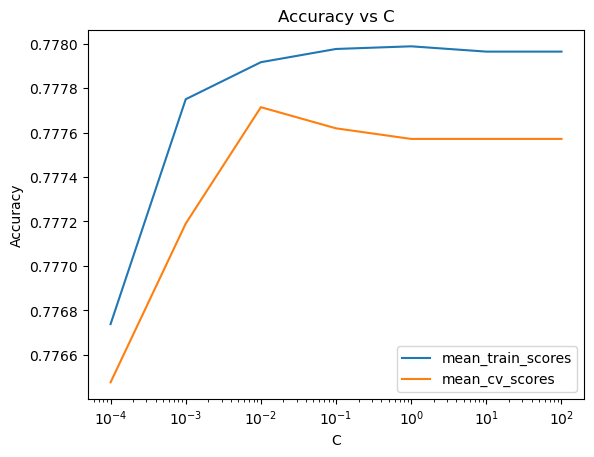

In [28]:
results_df[['mean_train_scores', 'mean_cv_scores', 'C']].set_index('C').plot(logx=True)
plt.ylabel('Accuracy')
plt.title('Accuracy vs C')
plt.show()

We pick `C = 0.01` as it generates the highest validation score. And its cross-validation scores are:

In [29]:
results_df.iloc[3]

C                    0.100000
mean_train_scores    0.777976
std_train_scores     0.001706
mean_cv_scores       0.777619
std_cv_scores        0.009379
Name: 3, dtype: float64

### Summary

Our graph represents the fundamental trade-off of machine learning. As the training score increases, the gap between training score and validation score also increases. We see that when `C < 0.01` the model tends to be under-fit and when `C > 0.01` the model tends to be over-fit. We can also see that that the standard deviation is very small when `C` is optimal here at 0.01. This gives us more reason to trust our results.

However, note that even when `C` is optimal, the cross-validation score (0.77761) is very close to the result from the dummy model (0.77881); the cross-validation score is even lower! This shows that our linear model is not performing very well and we need to try new methods.

<!-- END QUESTION -->

<br><br>


## 7. Different models <a name="7"></a>
<hr>

I tried 3 other models aside from a linear model. One of these models was a tree-based ensemble model. I summarized my results in terms of overfitting/underfitting and fit and score times.

#### KNN:

In [30]:
pipe_knn = make_pipeline(ct, KNeighborsClassifier())
cross_val_results_knn = pd.DataFrame(
    cross_validate(pipe_knn, X_train, y_train, return_train_score=True)
)
cross_val_results_knn.rename(columns={'test_score': 'validation_score'}, inplace=True)

cross_val_results_knn.mean()

fit_time            0.018144
score_time          0.125269
validation_score    0.794381
train_score         0.839583
dtype: float64

#### LightGBM:

In [31]:
pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123))
cross_val_results_lgbm = pd.DataFrame(
    cross_validate(pipe_lgbm, X_train, y_train, return_train_score=True)
)
cross_val_results_lgbm.rename(columns={'test_score': 'validation_score'}, inplace=True)

cross_val_results_lgbm.mean()

fit_time            0.296917
score_time          0.007347
validation_score    0.814381
train_score         0.839262
dtype: float64

#### Random Forrest:

In [32]:
pipe_rf = make_pipeline(ct, RandomForestClassifier(max_depth=10, n_estimators=100, random_state=123))
cross_val_results_rf = pd.DataFrame(
    cross_validate(pipe_rf, X_train, y_train, return_train_score=True)
)
cross_val_results_rf.rename(columns={'test_score': 'validation_score'}, inplace=True)

cross_val_results_rf.mean()

fit_time            0.444642
score_time          0.028082
validation_score    0.814762
train_score         0.847238
dtype: float64

### Summary

We tried three other models besides the linear one: KNN, LightGBM, and Random Forrest.

The KNN model seems to be a case of overfitting. We see that the training score is the highest (0.8396) among the three but its validation score is the lowest (0.7944) and the validation score is only slightly better than the linear model (0.778). It has the shortest fit-time of all three but it has the longest score-time. These indicators show that this KNN model is not very accurate and not very practical in real use due to the relative long score-time.

The Random Forrest model performed the best of all three. It has the high train score and validation score (highest among the three), so it's unlikely that we are dealing with a case of underfitting. And the gap between the validation score and train score is small, so it's also unlikely that we have a case of overfitting. However, the model has the longest fit time, although its score time relatively fast compared to KNN. Overall, the Random Forrest model is accurate and practical.

The LightGBM model performed only slightly worse than the Random Forrest model. It generates a high enough validation score and train score, so it's unlikely that the model is underfitting. We can also see that The LightGBM model is slightly less overfit than the Random Forrest model, as the gap between the train score and the validation score for LightGBM is slightly lower (0.033 for Random Forrest; 0.025 for LightGBM). This is expected as Random Forrest models are known to have problems of overfitting. The LightBGM model only has a slightly shorter fit time, but it has the fastest score time of all three. This make the LightGBM model accurate and practical.

<!-- END QUESTION -->

<br><br>

## 8. Feature selection <a name="8"></a>
<hr>

I made some attempts to select relevant features.

I tried forward selection on my best performing model (Random Forrest):

In [33]:
from sklearn.feature_selection import SequentialFeatureSelector

pipe_rf_forward = make_pipeline(
    ct,
    SequentialFeatureSelector(LogisticRegression(max_iter=1000), 
                              direction="forward", 
                              n_features_to_select='auto', 
                              tol=None),
    RandomForestClassifier(max_depth=10, n_estimators=100, random_state=123),
)
cross_val_results_rf_forward = pd.DataFrame(
    cross_validate(pipe_rf_forward, X_train, y_train, return_train_score=True)
)

cross_val_results_rf_forward.rename(columns={'test_score': 'validation_score'}, inplace=True)

cross_val_results_rf_forward.mean()

fit_time            2.056993
score_time          0.027190
validation_score    0.815048
train_score         0.831619
dtype: float64

I don't see a significant improve in the validation score. Only a increase of 0.000286. I understand the forward selection doesn't guarantee the global optimal features. There might be other combinations of features that will generate a better validation score. Nonetheless, I decide to move on without feature selections.

<!-- END QUESTION -->

<br><br>

## 9. Hyperparameter optimization <a name="9"></a>
<hr>

I made some attempts to optimize hyperparameters for the models you've tried and summarize your results. I used both `sklearn`'s GridSearchCV and RandomizedSearchCV.

#### KNN:

In [34]:
# Define the hyperparameter values to be tested
n_neighbors = np.arange(1, 25, 2)  # Testing odd numbers from 1 to 23

# Create the parameter grid
KNN_param_grid = {
    "kneighborsclassifier__n_neighbors": n_neighbors
}

# Create the grid search object
KNN_grid_search = GridSearchCV(
    pipe_knn, KNN_param_grid, cv=5, n_jobs=-1, return_train_score=True
)

# Perform grid search
KNN_grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_n_neighbors = KNN_grid_search.best_params_['kneighborsclassifier__n_neighbors']

KNN_best_score = KNN_grid_search.best_score_

KNN_relevant = [
    "mean_test_score",
    "param_kneighborsclassifier__n_neighbors",
    "rank_test_score"
]
pd.DataFrame(KNN_grid_search.cv_results_)[KNN_relevant].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12
mean_test_score,0.811714,0.811381,0.811048,0.810762,0.810714,0.810143,0.808048,0.80519,0.801952,0.794381,0.775143,0.724286
param_kneighborsclassifier__n_neighbors,21,23,17,19,15,13,11,9,7,5,3,1


In [35]:
print(f"The best cross-validation score is {KNN_best_score} with hyperparameter n_neighbors = {best_n_neighbors}.")

The best cross-validation score is 0.8117142857142857 with hyperparameter n_neighbors = 21.


#### LightGBM:

In [36]:
pipe_lgbm_op = make_pipeline(ct, LGBMClassifier(random_state=123))

LGBM_param_dist = {
    "lgbmclassifier__num_leaves": randint(1, 101),
}
LGBM_random_search = RandomizedSearchCV(
    pipe_lgbm_op, LGBM_param_dist, n_iter=10, verbose=1, n_jobs=-1, random_state=123
)

LGBM_random_search.fit(X_train, y_train)

best_num_leaves = LGBM_random_search.best_params_['lgbmclassifier__num_leaves']

LGBM_best_score = LGBM_random_search.best_score_

LGBM_relevant = [
    "mean_test_score",
    "param_lgbmclassifier__num_leaves",
    "rank_test_score",
]
pd.DataFrame(LGBM_random_search.cv_results_)[LGBM_relevant].set_index("rank_test_score").sort_index().T

Fitting 5 folds for each of 10 candidates, totalling 50 fits


rank_test_score,1,2,3,4,5,6,7,8,9,10
mean_test_score,0.816524,0.813714,0.812524,0.812238,0.812095,0.812,0.811905,0.811571,0.811524,0.811286
param_lgbmclassifier__num_leaves,18,48,58,93,99,67,87,84,98,97


In [37]:
print(f"The best cross-validation score is {LGBM_best_score} with hyperparameter num_leaves = {best_num_leaves}.")

The best cross-validation score is 0.8165238095238095 with hyperparameter num_leaves = 18.


#### Random Forrest:

In [38]:
pipe_rf_op = make_pipeline(ct, RandomForestClassifier(n_estimators=100, random_state=123))

rf_param_dist = {
    "randomforestclassifier__max_depth": randint(1, 10),
    "randomforestclassifier__max_features": randint(1, 10),
}
rf_random_search = RandomizedSearchCV(
    pipe_rf_op, rf_param_dist, n_iter=8, verbose=1, n_jobs=-1, random_state=123
)

rf_random_search.fit(X_train, y_train)

best_max_depth = rf_random_search.best_params_['randomforestclassifier__max_depth']
best_max_features = rf_random_search.best_params_['randomforestclassifier__max_features']

rf_best_score = rf_random_search.best_score_

rf_relevant = [
    "mean_test_score",
    "param_randomforestclassifier__max_depth",
    "param_randomforestclassifier__max_features",
    "rank_test_score",
]
pd.DataFrame(rf_random_search.cv_results_)[rf_relevant].set_index("rank_test_score").sort_index().T

Fitting 5 folds for each of 8 candidates, totalling 40 fits


rank_test_score,1,2,3,4,5,6,7,7
mean_test_score,0.818667,0.817571,0.813476,0.809,0.805571,0.800714,0.796381,0.796381
param_randomforestclassifier__max_depth,4,7,3,5,1,1,2,2
param_randomforestclassifier__max_features,7,2,3,1,5,4,1,1


In [39]:
print(f"The best cross-validation score is {rf_best_score} with hyperparameter max_depth = {best_max_depth} and max_features = {best_max_features}.")

The best cross-validation score is 0.8186666666666668 with hyperparameter max_depth = 4 and max_features = 7.


<!-- END QUESTION -->

<br><br>

## 10. Interpretation and feature importances <a name="10"></a>
<hr>

I sued `eli5` and `shap` to examine the most important features of one of the non-linear models.

In [40]:
import eli5

pipe_rf = make_pipeline(ct, RandomForestClassifier(max_depth=4, max_features=7, n_estimators=100, random_state=123))
pipe_rf.fit(X_train, y_train)
pipe_rf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'AGE']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(categories=[['married',
                                                                                              'single',
                                                                                              'others']]))]),
                                                  ['MARRIAGE']),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['EDUCATION', 'PAY_0',
                                                   'PAY_2', 'PAY_3', 'PAY_4',
                                                   'PAY_5', 'PAY_6']),
                                                 ('drop', 'drop',
                                                  ['ID', 'SEX', 'BILL_AMT1',
                                                   'BILL_AMT2', 'BILL_AMT3',
                                                   'BILL_AMT4', 'BILL_AMT5',
                                                   'BILL_AMT6', 'PAY_AMT1',
                                                   'PAY_AMT2', 'PAY_AMT3',
                                                   'PAY_AMT4', 'PAY_AMT5',
                                                   'PAY_AMT6'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, max_features=7,
                                        random_state=123))])

In [41]:
eli5.explain_weights(pipe_rf.named_steps['randomforestclassifier'], feature_names=column_names)

Weight,Feature
0.5425 ± 0.4321,PAY_0
0.2334 ± 0.4262,PAY_2
0.1099 ± 0.3434,PAY_3
0.0459 ± 0.1564,PAY_4
0.0253 ± 0.1040,PAY_5
0.0212 ± 0.0250,LIMIT_BAL
0.0130 ± 0.0228,PAY_6
0.0052 ± 0.0077,AGE
0.0012 ± 0.0040,EDUCATION
0.0009 ± 0.0037,MARRIAGE_married


### Summary of Feature Importance

`eli5` tells me that features `PAY_0`, `PAY_2`, `PAY_3` are most important of all features. They have scores that are high enough to be significant. This somewhat matches up with our intuition. It's certainly true that one can foresee whether a customer will default on his or her payment next month, from the payment status of previous months (`PAY_0`, `PAY_2`, `PAY_3`).

<!-- END QUESTION -->

<br><br>

## 11. Results on the test set <a name="11"></a>
<hr>


I tried my best performing model on the test data and report test scores, and explained individual predictions with SHAP force plots.

I found that the Random Forest Model has the highest cross validation score among all the candidate models when optimizing the hyperparameters, I scored the Random Forest model on the test data.

In [42]:
pipe_rf_final = make_pipeline(ct, RandomForestClassifier(n_estimators=100, max_depth = 4, max_features = 7, random_state=123))
pipe_rf_final.fit(X_train, y_train)
test_score_final = pipe_rf_final.score(X_test, y_test)
print("our final test score is " + str(test_score_final))

our final test score is 0.8237777777777778


In [43]:
X_train.shape

(21000, 24)

The test score is in line with the validation score from before. In fact, the test score is pretty close to my cross validation score. My model is not so complex (max_depth = 4 and max_features = 7), and the test score is not significantly lower than cross validation score. 

I think my result is trustworthy. As we can see that my training data set is abundant and I am only doing 5-fold cross validation. So, it's unlikely that I have a case of testing on the validation split over and over again. It's unlikely that I have a case of optimization bias.

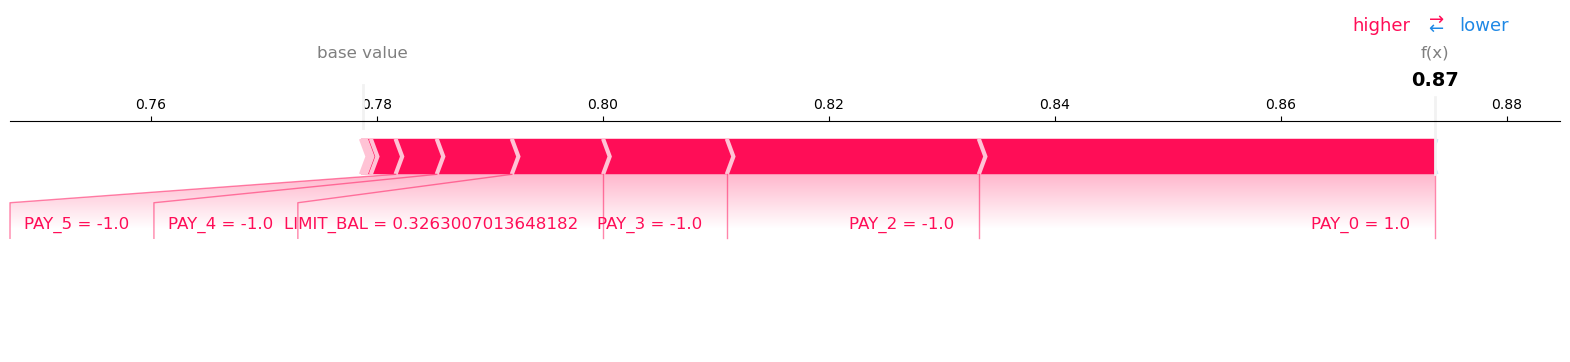

In [44]:
import shap

# Since we are dealing with a pipeline, the Random Forest model is the last step in the pipeline.
model = pipe_rf_final.named_steps['randomforestclassifier']

X_test_transformed = ct.transform(X_test)

df_shap = pd.DataFrame(X_test_transformed, columns=column_names)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed)

# Choose a specific instance for which you want the SHAP values
# Here we choose the first instance in the test set (index 0)
instance_index = 0

# Plot the SHAP values for that instance
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][instance_index, :],
    df_shap.iloc[instance_index, :],
    matplotlib=True,
)

From the `SHAP` graph, we can see that our Random Forrest model initially gives everyone a chance of 78% to financial default. This makes sense as it agrees with our results from the dummy model. And `SHAP` decided that only six of all features have predictive power in this case: `PAY_0`, `PAY_2`, `PAY_3`, `PAY_4`, `PAY_5`, and `LIMIT_BAL`.

Some parts of the graph match up with our intuition. For example, `PAY_0 = 1` moved the probability of default from 83% to 87%. This makes sense as someone who didn't pay his or her debt on time in the previous month will likely to default in the next month. However, other parts of the graph make less sense intuitively. We see that `PAY_2 = PAY_3 = PAY_4 = PAY_5 = -1`, which means that this person has a good track record of paying debt on time, but our model nonetheless thought that these features increase his or her likelihood to default next month, although the increase is relatively small.

<!-- END QUESTION -->

<br><br>

## 12. Summary of results <a name="12"></a>
<hr>

### Evaluation with Confusion Matrix

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay

In [46]:
pipe_rf_final.named_steps['randomforestclassifier'].classes_

array([0, 1])

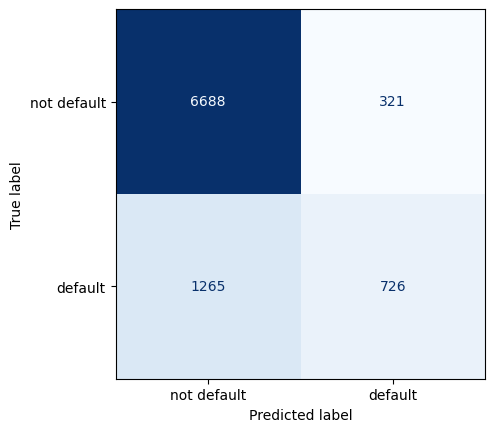

In [47]:
disp = ConfusionMatrixDisplay.from_estimator(
    pipe_rf_final,
    X_test,
    y_test,
    display_labels = ['not default','default'],
    values_format='d',
    cmap=plt.cm.Blues,
    colorbar=False,
)

In [48]:
print(classification_report(y_test, pipe_rf_final.predict(X_test), target_names=['not default', 'default'], digits=4))

              precision    recall  f1-score   support

 not default     0.8409    0.9542    0.8940      7009
     default     0.6934    0.3646    0.4779      1991

    accuracy                         0.8238      9000
   macro avg     0.7672    0.6594    0.6860      9000
weighted avg     0.8083    0.8238    0.8020      9000



From confusion matrix, we can see that, although our model has a relatively high test score (82.3%), the model has a low recall rate and precision rate.

A recall rate of 36.4% means that of all cases of actual default, our model can only predict 36.4% of cases. And a precision rate of 69.3% means that of all predicted default cases, about 69.3% of them are predicted correctly.

### Summary of Final Results

**Model: Random Forrest**

| hyperparameters                | baseline | mean cross-validation score | test score | recall | precision |
| :----------------------------: | :------------------------:|:-------------------------: | :--------: | :----: | :--------:|
| max_depth = 4; max_features = 7|  77.88%                   |     81.87%                 | 82.38%     | 36.46% | 69.34%    |

### Conclusion & Further Discussions

Overall my model is performing modestly. My final test score (82.38%) is slightly better than the baseline (77.88%). And most importantly my recall rate is abysmal at 36.46%, which means that our model missed most of the actual default cases. My model needs serious improvement before deployment.

In hindsight, we can improve our model by feature engineering. It was reckless on my part to drop `BILL_AMTn` and `PAY_AMTn` altogether. Although they don't seem to have predicting power on their own, it's reasonable to think that one could extract new features from them by doing non-linear combinations. We could define,

$$\mathrm{Percentage~Paid} = \frac{\mathrm{PAY\_AMT}}{\mathrm{BILL\_AMT}}$$

The reasoning could be that if a customer consistently paid a bare minimum to avoid default in the previous months, then he or she would be likely to default in the next month.